# Data Wrangling & EDA

In this project, we will be doing analysis on airline sentiments based on a tweet dataset pulled from kaggle. We will attempt to predict airline sentiments by using Natural Language Processing techniques. Let us first import a couple of the necessary packages as well as our dataset. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction import text
import re
import contractions

In [2]:
data = pd.read_csv('../data/Tweets.csv.zip')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

## Initial Exploration

We can see that, while there are several columns with many missing values, our target column (airline_sentiment) has no missing values. Let us look at the value counts for our target variable and some of our critical features. 

In [5]:
data.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

The vast majority of the airline sentiments are negative, followed by neutral and lastly positive. We will look at the distributions for each airline shortly. 

In [6]:
data.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [7]:
data.negativereason.isna().sum()

5462

Over 5000 of the tweets do not have a negative reason listed. Let us fill all of these null values with "No Reason". 

In [8]:
data['negativereason'] = data['negativereason'].fillna("No Reason")
data.negativereason.value_counts()

No Reason                      5462
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

We will now get rid of all columns that will not be useful in our analysis, and save this as a new dataframe called "df".

In [9]:
df = data[['airline_sentiment','negativereason','airline','retweet_count','text']]
df.head()

,airline_sentiment,negativereason,airline,retweet_count,text
0,neutral,No Reason,Virgin America,0,@VirginAmerica What @dhepburn said.
1,positive,No Reason,Virgin America,0,@VirginAmerica plus you've added commercials t...
2,neutral,No Reason,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...
3,negative,Bad Flight,Virgin America,0,@VirginAmerica it's really aggressive to blast...
4,negative,Can't Tell,Virgin America,0,@VirginAmerica and it's a really big bad thing...


Let's now visualize the negative reasons and airline sentiments for each airline. 

In [10]:
def stacked_bar(x, y, df, colormap, xlabel, title):
    #Create cross tabulation for proportion for each category
    cross_tab_prop = pd.crosstab(index=df[x], 
                                 columns=df[y], 
                                 normalize="index")
    cross_tab = pd.crosstab(index=df[x], 
                            columns=df[y])
    #create stacked bar chart
    cross_tab_prop.plot(kind='bar', 
                        stacked=True, 
                        colormap=colormap, 
                        figsize=(10, 10))
    plt.legend(bbox_to_anchor=(1.0, 1.0), 
               loc='upper left')
    plt.xlabel(xlabel)
    plt.xticks(rotation=45)
    plt.ylabel("Proportions")
    plt.title(title)
    
    for n, x in enumerate([*cross_tab.index.values]):
        for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                       cross_tab_prop.loc[x].cumsum()):
                
            plt.text(x=n-0.16,
                     y=(y_loc - proportion) + (proportion / 2),
                     s=f'{np.round(proportion * 100, 1)}%', 
                     color="black",
                     fontsize=10,
                     fontweight="bold")

    plt.show()

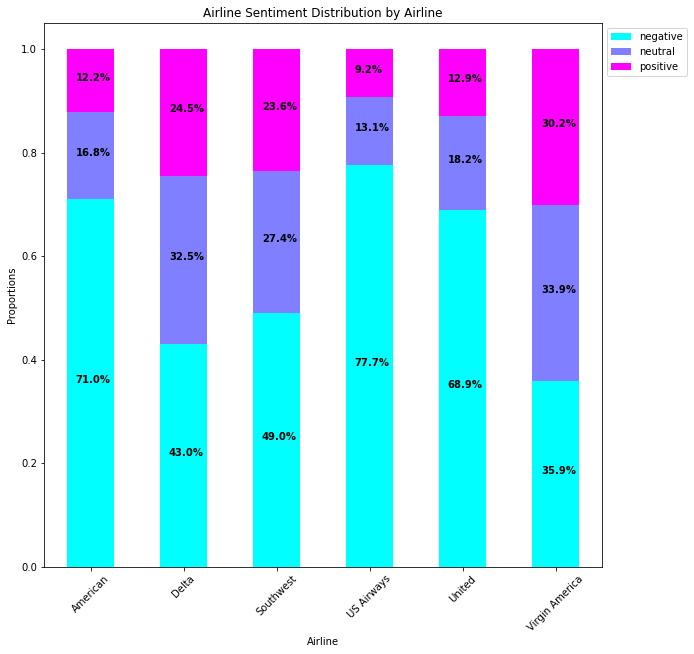

In [11]:
stacked_bar('airline', 'airline_sentiment', df, 'cool', 'Airline','Airline Sentiment Distribution by Airline')

The tweets about US Airways, American, and United have negative sentiments in well over half of them. The sentiments for Virgin America are pretty evenly split, yet they have the least tweets about them as well. Let's now look at the distributions of negative reasons for each airline. First, we should get rid of the "No Reason" value as this will not provide much information. 

In [12]:
df_negreasons = df[df['negativereason'] != 'No Reason']

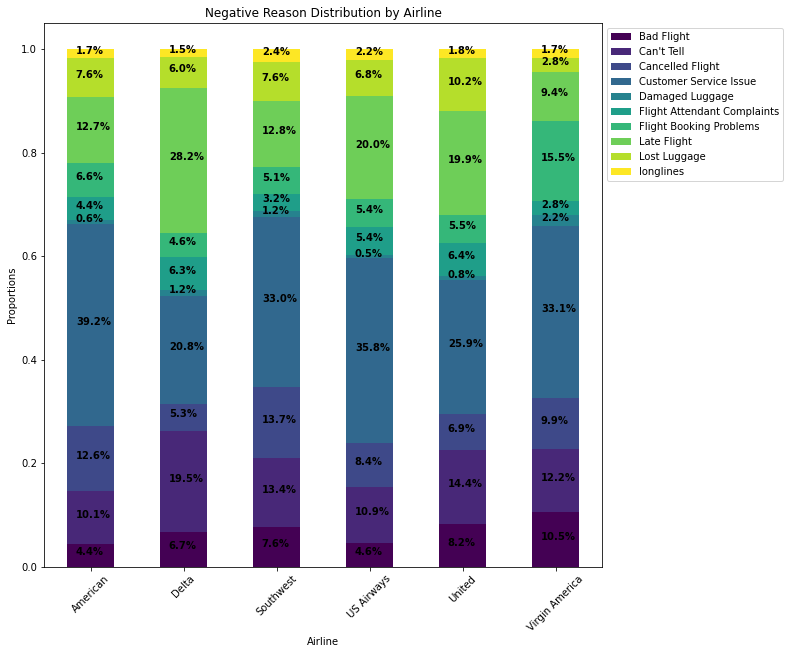

In [13]:
stacked_bar('airline', 'negativereason', df_negreasons, 'viridis', 'Airline','Negative Reason Distribution by Airline')

Customer service issues seem to be the leading reason for negative sentiment across all airlines, except for Delta, which had late flight as the leading negative sentiment. Let us gain some further insights by buildling word clouds for each sentiment. 

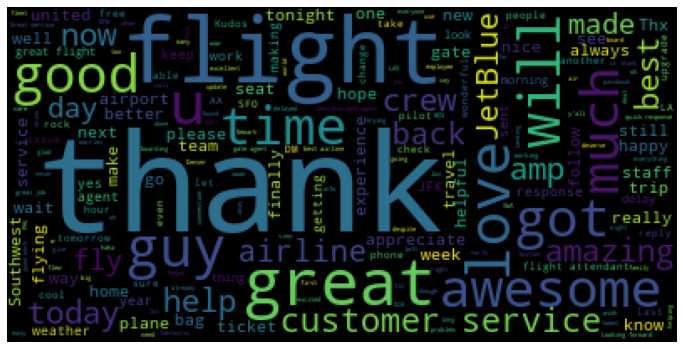

In [14]:
#Import WordCloud and STOPWORDS from wordcloud module
from wordcloud import WordCloud, STOPWORDS

#Get only positive sentiment samples
df_positive = df[df['airline_sentiment']=='positive']

#Join all tweets together into one long text document separated by spaces
full_text = ' '.join(df_positive['text'])

#Now, get rid of words with the @ (these are just account tags), as well as website links (which start with http)
clean_text = " ".join([word for word in full_text.split() 
                       if 'http' not in word 
                       and not word.startswith('@')])

#create the wordcloud, including a stopwords paramete
wordcloud = WordCloud(stopwords=STOPWORDS).generate(clean_text)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Immediately we see words like thank, great, customer service, love, flight, and awesome associated with airlines with positive sentiments. 

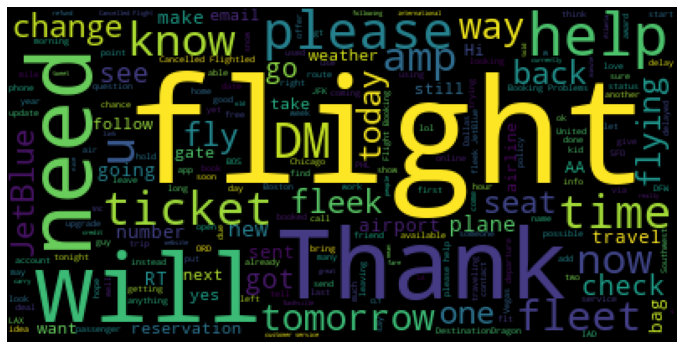

In [15]:
#Get only neutral sentiment samples
df_neutral = df[df['airline_sentiment']=='neutral']

#Join all tweets together into one long text document separated by spaces
full_text = " ".join(df_neutral['text'])

#Now, get rid of words with the @ (these are just account tags), as well as website links (which start with http)
clean_text = " ".join([word for word in full_text.split() 
                       if 'http' not in word 
                       and not word.startswith('@')])

#create the wordcloud, including a stopwords parameter
wordcloud = WordCloud(stopwords=STOPWORDS).generate(clean_text)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

For neutral sentiment tweets about airlines, words associated include flight, help, please, tomorrow, time, thank, and fly. 

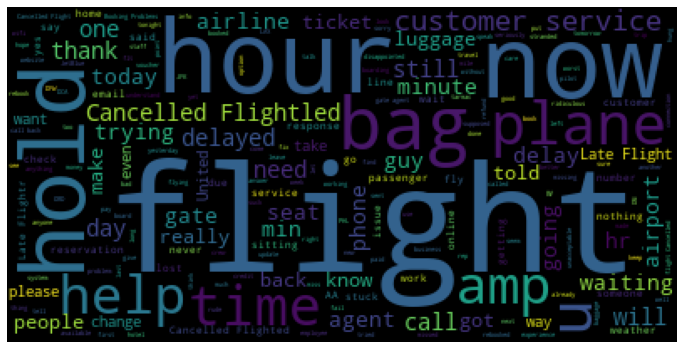

In [16]:
#Get only negative sentiment samples
df_negative = df[df['airline_sentiment']=='negative']

#Join all tweets together into one long text document separated by spaces
full_text = " ".join(df_negative['text'])

#Now, get rid of words with the @ (these are just account tags), as well as website links (which start with http)
clean_text = " ".join([word for word in full_text.split() 
                       if 'http' not in word 
                       and not word.startswith('@')])

#create the wordcloud, including a stopwords paramete
wordcloud = WordCloud(stopwords=STOPWORDS).generate(clean_text)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

For negative sentiment tweets, we see common words such as bag, time, hour, help, hold. These tweets are probably referring to issues with bags, flight timing, and customer service. 

## Text Cleaning

We will now do some text cleaning to do further analysis. 

In [17]:
#Check if there are any tweets with leading or ending spaces
print(df['text'].str.startswith(' ').sum())
print(df['text'].str.endswith(' ').sum())

0
0


In [18]:
def clean_tweet(tweet):
    #make all words lowercase
    lower = tweet.lower() 
    #remove all words starting with @ (this will remove all @ mentions from tweets)
    no_tags = " ".join([i for i in lower.split() if not i.startswith('@')]) 
    #split contractions into words
    expanded_text = " ".join([contractions.fix(i) for i in no_tags.split()])
    #remove all non-alphabetical characters
    alpha = re.sub("[^a-zA-Z ]", "", expanded_text)
    #create set of stop words
    stop_words = set(text.ENGLISH_STOP_WORDS)           
    #tokenize words
    tokens = nltk.word_tokenize(alpha)
    #initiate lemmatizer
    lemmatizer = nltk.WordNetLemmatizer()
    #lemmatize tokens
    lemmatized = [lemmatizer.lemmatize(i) for i in tokens]
    #remove stop words
    result = [i for i in lemmatized if not i in stop_words]
    #join words and return the clean tweets
    return(" ".join(result))

In [19]:
df['text_clean'] = df['text'].apply(clean_tweet)
df.head()

<ipython-input-19-daa1856a5524>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_clean'] = df['text'].apply(clean_tweet)


,airline_sentiment,negativereason,airline,retweet_count,text,text_clean
0,neutral,No Reason,Virgin America,0,@VirginAmerica What @dhepburn said.,said
1,positive,No Reason,Virgin America,0,@VirginAmerica plus you've added commercials t...,plus added commercial experience tacky
2,neutral,No Reason,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...,did today mean need trip
3,negative,Bad Flight,Virgin America,0,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,negative,Can't Tell,Virgin America,0,@VirginAmerica and it's a really big bad thing...,really big bad thing


In [20]:
df.shape

(14640, 6)

In [21]:
#Some values in text_clean column may be empty after processing, we will want to remove these
df[df.text_clean == ''].head()

,airline_sentiment,negativereason,airline,retweet_count,text,text_clean
669,neutral,No Reason,United,0,@united Done and done,
781,positive,No Reason,United,0,@united you too!,
988,neutral,No Reason,United,0,@united done,
2258,negative,Can't Tell,United,0,@united never again.,
2603,neutral,No Reason,United,0,@united @SCVPools \nPlease call me at 310-795-...,


In [22]:
df = df[df.text_clean != '']
df.shape

(14590, 6)

Lastly, before we begin modeling, we should get rid of all neutral sentiment tweets. Trying to predict a neutral sentiment does not have much business use since there are no actions to be taken on a neutral tweet. We will make this a binary classification model, where we are only trying to predict whether a tweet has positive or negative sentiment. 

In [23]:
df = df[df['airline_sentiment'] != 'neutral']
df.shape

(11523, 6)

In [24]:
df.reset_index(inplace=True,drop=True)
df.to_csv("../data/clean_data.csv")